# Do We Need Convolutional Neural Networks?

### **1. Introduction & Motivation** 

**Why Do We Need Convolutional Neural Networks?**

Up to this point, we have explored image classification using **Multilayer Perceptrons (MLPs)**. While MLPs are powerful in theory — capable of approximating any function — they begin to show severe limitations when applied to image data. Understanding these limitations naturally motivates the introduction of **Convolutional Neural Networks (CNNs)**.

In [1]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112912782", h="3298dbabb7", width=700, height=450)

**The Limitations of MLPs for Image Data**

An image is not just a flat collection of pixel values. Each pixel has a **spatial relationship** with its neighbors, forming edges, textures, and shapes that convey meaning. However, when we feed images into an MLP, we typically **flatten them into one-dimensional vectors** (for example, a `3×32×32` image becomes a vector of length 3,072). This flattening operation destroys the spatial structure of the image, forcing the network to treat each pixel as independent and unrelated to its neighbors.

In [2]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112912993", h="3298dbabb7", width=700, height=450)

Moreover, fully connected layers in MLPs require a parameter for every connection between input and hidden units. For even moderately sized images, this leads to **millions of parameters**. Such large parameter counts are not only inefficient to train but also prone to **overfitting** — the model memorizes training data instead of learning generalizable patterns.

In [3]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112913213", h="3298dbabb7", width=700, height=450)

Perhaps most importantly, MLPs must **learn the same visual feature repeatedly in different locations**. For example, an edge at the top-left corner of an image is no different from an edge in the bottom-right corner — yet an MLP cannot exploit this fact and must relearn it for every position.

One subtle yet crucial limitation of MLPs is that they **do not understand that the same pattern can appear anywhere in the image**. 

Think about detecting a simple pattern like an **edge** (a sharp boundary between light and dark pixels). This edge could appear at the **top-left corner** of an image (e.g., edge of a cat’s ear), or at the **bottom-right corner** (e.g., edge of the same cat’s tail). From a human perspective, these are obviously **the same kind of feature** (an “edge”) — we recognize it no matter where it appears.  

In [4]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112913105", h="3298dbabb7", width=700, height=450)

But an MLP, after flattening the image, treats each pixel as **independent**. It learns a separate weight for every pixel location. This means:
- The model must **relearn what an edge looks like at every possible location** in the image.
- As images grow in size, this leads to **massive duplication of effort** and **wasted parameters** — each edge position is “rediscovered” separately.

In other words, MLPs fail to take advantage of the fact that **visual patterns repeat across the image**. This is where CNNs come in.

**Enter Convolutional Neural Networks (CNNs)**

Convolutional Neural Networks were designed to **fix these exact problems** by taking inspiration from how our visual system works. Instead of connecting every pixel to every neuron, CNNs introduce three powerful ideas:

1. **Local Receptive Fields**: Rather than looking at the entire image at once, CNNs use small “windows” (like `3×3` or `5×5` grids) that **scan small parts of the image at a time**. Each window focuses on **local patterns**, such as detecting edges, corners, or simple textures. This is similar to how our eyes process only a small patch of the visual field at a time and then combine information from multiple patches.

2. **Parameter Sharing**: The same filter (set of weights) is **reused** as it slides across different parts of the image. For example, a filter that detects horizontal edges will work anywhere in the image — **top, bottom, or center**. This dramatically reduces the number of parameters compared to an MLP and ensures the model **remembers what it learned about an edge regardless of location**.

3. **Hierarchical Feature Learning**: CNNs build knowledge **layer by layer**:
   - Early layers detect **simple features** (e.g., edges, corners).
   - Middle layers detect **patterns or textures** (e.g., fur, eyes).
   - Deeper layers detect **complex objects** (e.g., faces, entire animals).

This hierarchy allows CNNs to construct an understanding of the image **from simple to complex**, mirroring how humans perceive visual information.

**Looking Ahead**

In this notebook, we begin our journey into CNNs by **building intuition** rather than training large models. We will explore the basic building blocks — **convolutions, feature maps, and pooling operations** — and see why they work so well for image classification. This understanding will prepare us for constructing full CNN architectures in later notebooks.

Next, let us introduce the dataset we will use to explore these concepts: the **Oxford-IIIT Pets dataset**, which provides a diverse collection of pet images spanning multiple breeds.

---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section.**

---

### **2.🐾 Image Representation and Dataset**

- Images are stored as **tensors**: multi-dimensional arrays of numbers.
- In PyTorch, the format is usually **C × H × W**:
  - **C** = Number of channels (e.g., 3 for RGB, 1 for grayscale)
  - **H** = Height (number of rows)
  - **W** = Width (number of columns)

For example, a **32×32 RGB image** will have 3 channels (Red, Green, Blue), each channel having a 32×32 grid, and thus total shape: `3 × 32 × 32`.

Each pixel in a color image has **three values**: R (Red) intensity, G (Green) intensity, B (Blue) intensity.

Pixel values in the raw dataset range from 0 to 255. When we apply the `ToTensor()` transform provided by `torchvision`, these values are converted to floats in the range `0.0–1.0`. Later in the pipeline, we often apply **normalization** using the mean and standard deviation of the dataset to center and scale the pixel values, which helps with training stability.

**Toy Example: RGB Patch**

Imagine a **$3 \times 3$ patch** of an image (zoomed in):

**Red Channel ($3 \times 3$)** <--> **Green Channel ($3 \times 3$)** <--> **Blue Channel ($3 \times 3$)**


\begin{bmatrix}
123 & 50 & 90 \\
100 & 60 & 120 \\
90 & 30 & 60
\end{bmatrix}

\begin{bmatrix}
34 & 200 & 80 \\
20 & 150 & 70 \\
15 & 180 & 50
\end{bmatrix}

\begin{bmatrix}
90 & 10 & 255 \\
80 & 40 & 210 \\
60 & 30 & 190
\end{bmatrix}


When combined, these three matrices reconstruct the **color pixel information** for that patch.

**Why Does This Matter for CNNs?**: **Convolutional filters** will operate across **all channels** simultaneously. The way images are stored ($C \times H \times W$) directly affects how we design convolution layers. Understanding this format is crucial before we discuss **filters, strides, and feature maps**.

**The Oxford-IIIT Pets Dataset and How Images Are Represented**

To ground our study of CNNs in a realistic context, we will use the **Oxford-IIIT Pets dataset**. This dataset contains images of 37 different cat and dog breeds, totaling around 7,400 images. Each image varies in resolution and background, providing a rich and challenging classification task.

Unlike the CIFAR-10 dataset we worked with previously, which contains only 10 classes and relatively low-resolution images (32×32 pixels), the Oxford-IIIT Pets dataset is more diverse and better represents real-world conditions. This makes it an excellent stepping stone toward more advanced image classification tasks.

The dataset includes 37 breeds, covering both cats and dogs. Each image is annotated with a class label — an integer from 0 to 36 — that corresponds to a specific breed name (e.g., `Abyssinian`, `Bengal`, `Birman`, `Maine Coon`, `Persian`). When training a model, we typically work with these numeric labels, but we map them back to human-readable names for interpretation.

**What We Will Do in This Section**

In this section, we will load the dataset using `torchvision.datasets`, apply a simple transformation (resize and convert to tensor), and then inspect its properties:

- How many images are there?
- What is the shape of an image tensor?
- What are the class names?
- How do sample images look?

By visualizing a few samples, we gain an intuition for the dataset and confirm that preprocessing works as expected.

In [6]:
import os
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import numpy as np

In [7]:
# Point directly to the folder containing images/ and annotations/
data_path = "data/oxford-iiit-pet/"

# Check if expected subfolders exist (images + annotations)
images_exist = os.path.exists(os.path.join(data_path, "images"))
annots_exist = os.path.exists(os.path.join(data_path, "annotations"))

# Only download if either folder is missing
download_flag = not (images_exist and annots_exist)

print(f"Images exist: {images_exist}, Annotations exist: {annots_exist}")

Images exist: True, Annotations exist: True


**Check Original Resolutions**

In [4]:
from torchvision import datasets

# Load dataset without resizing to check original image sizes
raw_dataset = datasets.OxfordIIITPet(
    root="data",
    split="trainval",
    target_types="category",
    download=True,   # assuming you have to download it
    transform=None    # No transform → retains original size
)

# Inspect first few images for their original resolution
for i in range(3):
    img, label = raw_dataset[i]
    print(f"Original size of image {i}: {img.size} (W x H)")


Original size of image 0: (394, 500) (W x H)
Original size of image 1: (450, 313) (W x H)
Original size of image 2: (500, 465) (W x H)


**About `split="trainval"` in Oxford-IIIT Pet Dataset**

When we load the Oxford-IIIT Pet dataset using `torchvision.datasets.OxfordIIITPet`, we specify a `split` argument. This corresponds to how the dataset creators organized the files:

- `split="trainval"` → Loads **training + validation images combined**. These are listed in the file `trainval.txt` provided with the dataset.
- `split="test"` → Loads the official test set images listed in `test.txt`.

The `trainval.txt` file contains one line per image with **four pieces of information**:
```text 
<image_id> <class_id> <species> <breed_id> 
```

- **image_id** – The file name (e.g., `Abyssinian_100`)  
- **class_id** – The numeric label for the breed (1–37)  
- **species** – 1 = cat, 2 = dog  
- **breed_id** – Purebred indicator (1) or mixed (2)  

For our classification task, we primarily use **class_id** (breed label). The species and purebred indicators are not needed here.

> **Note:** The `trainval` split does **not separate training and validation internally** — we will manually split it (e.g., 80/20) later when training models.

Now, we will reload the images, resize them for manageable training, convert them to tensors, and visualize a few random samples to understand the data we’ll be working with.

Number of images: 3680
Number of classes: 37
Example classes: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle']


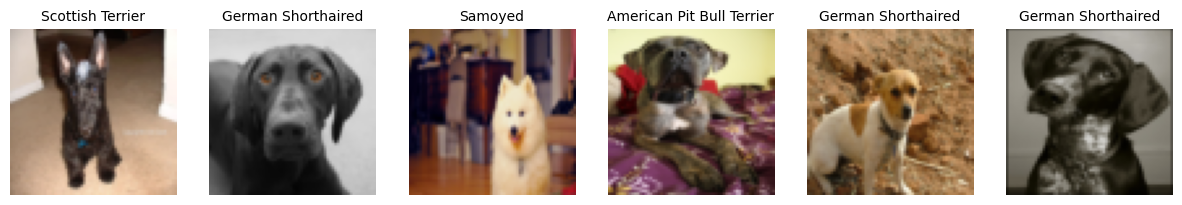

In [8]:
# Define transformations: resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((64, 64)),   # Resize for easier visualization and manageable training
    transforms.ToTensor()          # Convert to tensor, scales pixels to [0, 1]
])

# Load the Oxford-IIIT Pets dataset
train_dataset = datasets.OxfordIIITPet(
    root="./data/",
    split="trainval",
    target_types="category",
    download=download_flag,
    transform=transform
)

# Inspect dataset properties
print(f"Number of images: {len(train_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Example classes: {train_dataset.classes[:5]}")

# Visualize random samples
def show_samples(dataset, n=6):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert CHW → HWC
        axes[i].set_title(dataset.classes[label], fontsize=10)
        axes[i].axis("off")
    plt.show()

show_samples(train_dataset)

**Visual Comparison: Original vs Resized**

To better understand why we resize images for training:

- **Original image**: High resolution, varied sizes, more details.
- **Resized image (64×64)**: Standardized, smaller, faster to process.

We trade off some detail for **training speed and consistency**.


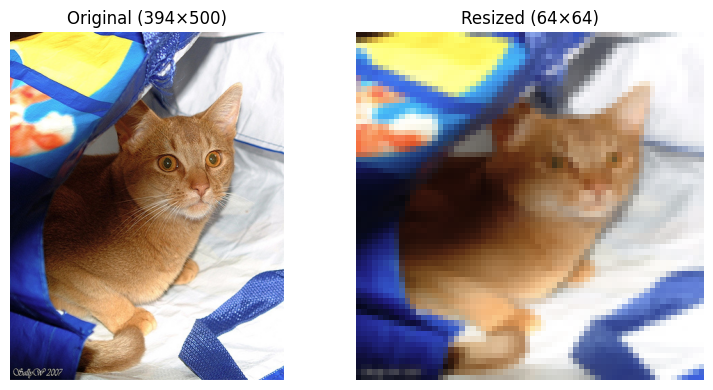

In [19]:
import matplotlib.pyplot as plt
raw_dataset = datasets.OxfordIIITPet(
    root="./data",
    split="trainval",
    target_types="category",
    download=True,
    transform=CT_raw_transform
)
# Select a random sample index
idx = 0
orig_img, label = raw_dataset[idx]        # Original (PIL image)
resized_img, _ = train_dataset[idx]       # Resized (Tensor 64×64)

# Convert resized tensor back to PIL for display
resized_img_pil = transforms.ToPILImage()(resized_img)

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Original image
axs[0].imshow(orig_img)
axs[0].set_title(f"Original ({orig_img.size[0]}×{orig_img.size[1]})")
axs[0].axis("off")

# Resized image
axs[1].imshow(resized_img_pil)
axs[1].set_title("Resized (64×64)")
axs[1].axis("off")

plt.tight_layout()
plt.show()

---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section.**

---

**✅ Code Task 5.1.2.1: Load and Transform a Subset of Oxford-IIIT Pet Dataset**

📘 Instruction </br>
Your task is to load a subset of 100 images from the Oxford-IIIT Pet dataset with a custom transform that resizes each image to (32×32). Then, pick one sample and display the original image and the resized version side-by-side.

Hints: 
- Use Subset to extract 100 images.
- Use ToPILImage() to convert a tensor back to an image for display.
- Use plt.subplots() for side-by-side visualization.

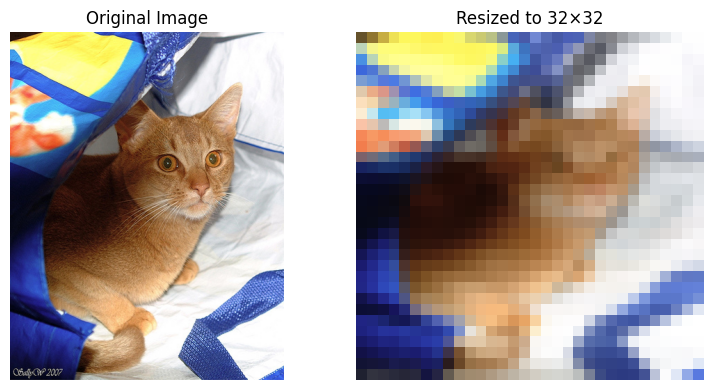

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt

# --- 1. Define transforms ---

# No transform (keep original PIL images)
CT_raw_transform = None  

# Resize transform to 32x32
CT_transform_32 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# --- 2. Load the Oxford-IIIT Pet dataset ---
# Original dataset (no resizing)
raw_dataset = datasets.OxfordIIITPet(
    root="./data",
    split="trainval",
    target_types="category",
    download=True,
    transform=CT_raw_transform
)

# Resized dataset (32×32)
CT_dataset_32 = datasets.OxfordIIITPet(
    root="./data",
    split="trainval",
    target_types="category",
    download=False,
    transform=CT_transform_32
)

# --- 3. Extract subset of first 100 samples ---
CT_subset_32 = Subset(CT_dataset_32, list(range(100)))

# --- 4. Visualize one sample ---
idx = 0
CT_orig_img, _ = raw_dataset[idx]         # Original PIL image
CT_resized_img, _ = CT_subset_32[idx]     # Resized tensor

# Convert resized tensor back to PIL for visualization
CT_resized_pil = transforms.ToPILImage()(CT_resized_img)

# --- 5. Plot both images side-by-side ---
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(CT_orig_img)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(CT_resized_pil)
axs[1].set_title("Resized to 32×32")
axs[1].axis("off")

plt.tight_layout()
plt.show()


---

## **3. What is a Convolution?**

In [21]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112913528", h="3298dbabb7", width=700, height=450)

Convolutional Neural Networks (CNNs) owe their power to a mathematical operation called **convolution**. This operation is very different from the fully connected layers we explored earlier, where **every input pixel connects to every neuron**. Convolution layers instead rely on **local connectivity** and **weight sharing**, which dramatically reduce parameters and make them ideal for detecting patterns in images.

**Why Convolution Instead of Fully Connected Layers?**

In an image, meaningful features like edges, corners, or textures are **local** — we don’t need to connect every pixel to every neuron to detect them. Instead, we scan small regions (patches) of the image with **filters** (also called **kernels**) that specialize in finding specific patterns (e.g., vertical edges, diagonal lines, color gradients).

In [22]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112913646", h="3298dbabb7", width=700, height=450)

In [24]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112913763", h="3298dbabb7", width=700, height=450)

**How Does It Work?**

A convolution layer slides a **filter (kernel)** across the image. At each position, it performs **element-wise multiplication** followed by a **sum** to produce a single output value. Repeating this across the image forms the **feature map**.

Mathematically, a 2D convolution is:

$$
S(i,j) = \sum_m \sum_n I(i+m, j+n) \cdot K(m,n)
$$

where:
- $ I $= input image  
- $ K $ = convolution filter  
- $ S $ = resulting feature map  

In [25]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112914056", h="3298dbabb7", width=700, height=450)


**Intuition: From Pixels to Patterns**

Imagine using a **stencil or cookie cutter**:  
- You place it on part of the image (a patch).  
- Check how well the pattern inside matches (dot product).  
- Slide it over and repeat — this is convolution!  

Or picture shining a **flashlight** on different areas:  
- A vertical edge filter “lights up” wherever vertical edges appear.  
- A horizontal edge filter “lights up” wherever horizontal edges appear.  

Stacking multiple filters allows CNNs to detect multiple features simultaneously.

In [23]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112914199", h="3298dbabb7", width=700, height=450)


**Key Hyperparameters**

1. **Filter Size (Kernel Size)**  
   - Typically $3 \times 3$ or $5 \times 5$.  
   - Larger filters capture bigger patterns but are more computationally expensive.

2. **Stride**  
   - How far the filter moves per step.  
   - Stride = 1: maximum overlap. Stride = 2: skips pixels (downsampling).

3. **Padding**  
   - Adds zeros around the border to preserve image size after convolution.  
   - Without padding, feature maps shrink after each layer.


**Why This Matters**

- **Parameter Efficiency:** A $3 \times 3$ filter uses 9 parameters but scans the whole image.  
- **Translation Invariance:** A detected edge is recognized regardless of its location.  
- **Hierarchical Learning:** Early layers detect edges → middle layers detect textures → deeper layers recognize objects.


**Example: Edge Detection**

A simple horizontal edge filter:

$$
\begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix}
$$

This highlights **horizontal changes** in intensity — transitions from dark to light.

**What’s Next**

In the next section, we’ll **implement convolution manually with NumPy**. This will give us an **intuitive feel** for how filters slide across an image and produce feature maps — before using PyTorch’s built-in functions.

---

In [26]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112914457", h="3298dbabb7", width=700, height=450)

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section.**

---

### **4. Manual Convolution Implementation (NumPy)**

**Why Implement Convolution Manually?**

Before relying on PyTorch’s `nn.Conv2d`, it’s vital to understand what’s happening “under the hood.” By manually coding convolution with **NumPy**, we will:

- Demystify how filters slide across an image.
- Visualize how edge detection or blurring emerges from simple arithmetic.
- Build intuition for **kernel size**, **stride**, and **padding**.


**Step 1: Create a Toy Image**

We will use a small **grayscale image** (e.g., $6 \times 6$ pixels) so calculations remain tangible.  
Each value represents pixel intensity ($0 =$ black, $255 =$ white).

For example:

$$
\begin{bmatrix}
10 & 10 & 10 & 0 & 0 & 0 \\
10 & 10 & 10 & 0 & 0 & 0 \\
10 & 10 & 10 & 0 & 0 & 0 \\
0  & 0  & 0  & 20 & 20 & 20 \\
0  & 0  & 0  & 20 & 20 & 20 \\
0  & 0  & 0  & 20 & 20 & 20
\end{bmatrix}
$$

This toy image contains **two contrasting blocks** (dark vs. bright) — perfect for testing edge detection.

**Step 2: Define a Filter (Kernel)**

A **filter** is a small matrix, usually $3 \times 3$ or $5 \times 5$.  
For horizontal edge detection, we can use:

$$
\begin{bmatrix}
-1 & -1 & -1 \\
0  &  0 &  0 \\
1  &  1 &  1
\end{bmatrix}
$$

This highlights **horizontal changes** in pixel values.

**Step 3: Perform Convolution**

**Process:**

1. Place the filter at the **top-left** corner of the image.
2. Multiply overlapping values and **sum them up**.
3. Move the filter by **one pixel** (stride = 1) and repeat.
4. Continue until the filter slides across the entire image.


**Expected Outcome**

- The output (feature map) will highlight **edges** where pixel intensity changes rapidly.  
- For our toy image, the boundary between the top-left block (value $10$) and bottom-right block (value $20$) should appear as a **strong response**.

In the next cell, we will code this step-by-step, starting with a simple **2D convolution for grayscale images**.


Resulting Feature Map (Matrix):
[[  0.   0.   0.   0.]
 [-30.   0.  30.  60.]
 [-30.   0.  30.  60.]
 [  0.   0.   0.   0.]]


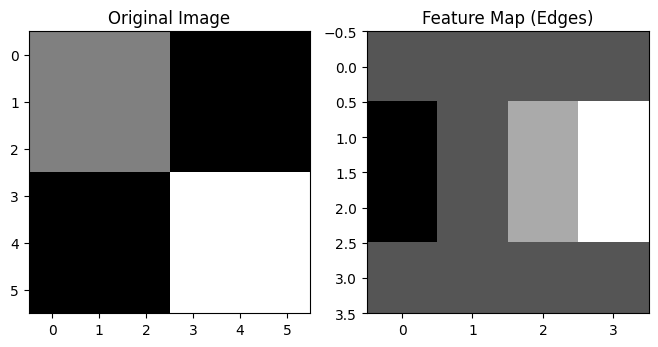

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a toy grayscale image (6x6)
image = np.array([
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [0, 0, 0, 20, 20, 20],
    [0, 0, 0, 20, 20, 20],
    [0, 0, 0, 20, 20, 20]
])

# Step 2: Define a 3x3 horizontal edge detection filter
kernel = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
])

# Step 3: Convolution operation
def convolve2d(image, kernel, stride=1, padding=0):
    # Add padding if specified
    if padding > 0:
        image = np.pad(image, ((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    
    kernel_height, kernel_width = kernel.shape
    img_height, img_width = image.shape

    # Calculate output dimensions
    out_height = (img_height - kernel_height) // stride + 1
    out_width = (img_width - kernel_width) // stride + 1

    # Initialize output feature map
    output = np.zeros((out_height, out_width))

    # Perform convolution
    for y in range(0, img_height - kernel_height + 1, stride):
        for x in range(0, img_width - kernel_width + 1, stride):
            region = image[y:y+kernel_height, x:x+kernel_width]
            output[y//stride, x//stride] = np.sum(region * kernel)

    return output

# Apply convolution
feature_map = convolve2d(image, kernel)

# Print resulting matrix for clarity
print("Resulting Feature Map (Matrix):")
print(feature_map)

# Visualize
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image")
axs[1].imshow(feature_map, cmap='gray')
axs[1].set_title("Feature Map (Edges)")
plt.show()


---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section.**

---

**✅ Code Task 5.1.4.1: Apply a Custom Edge Detection Filter on Toy Image**

📘 Instruction </br>
Use the convolve2d function (already defined in the notebook) to apply a custom diagonal edge detection kernel on the 6×6 toy grayscale image. Then, visualize the resulting feature map.

Hints:
- Define a new 3×3 kernel manually.
- Pass it to convolve2d(...).
- Use imshow() with cmap='gray' to visualize.

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define diagonal edge detection kernel (custom 3x3)
CT_diag_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
    
])

# Apply convolution using existing function
CT_diag_feature_map = convolve2d(image,CT_diag_kernel)

# Print resulting matrix for clarity
print("Resulting Feature Map (Matrix):")
print(CT_diag_feature_map)

Resulting Feature Map (Matrix):
[[  0.   0.   0.   0.]
 [-30.   0.  30.  60.]
 [-30.   0.  30.  60.]
 [  0.   0.   0.   0.]]


---

In [30]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112914718", h="3298dbabb7", width=700, height=450)

### **5. Feature Maps & Multi-Channel Convolutions**

**Why Multi-Channel Convolutions?**

Up to now, we’ve worked with **single-channel (grayscale)** images, where each pixel is represented by one intensity value.  
However, real-world images (like those in Oxford Pets) are **RGB** — meaning **3 channels** (Red, Green, Blue).

- Each channel is processed **independently** by the filter (kernel).
- The results are then **summed across channels** to form the final feature map.


**Mathematical Representation**

For a convolution filter with weights $W_R$, $W_G$, and $W_B$ applied to an RGB image:

$$
\text{Feature Map} = (W_R * I_R) + (W_G * I_G) + (W_B * I_B)
$$

Where:
- $I_R, I_G, I_B$ are the red, green, and blue channels of the image.
- $*$ denotes the 2D convolution operation.


**Multiple Filters → Multiple Feature Maps**

If we apply **N different filters**, we get **N feature maps**.  
Each map captures **different patterns** (e.g., vertical edges, horizontal edges, textures).

- Each filter learns to detect **specific features**.
- Stacking feature maps lets the network represent complex structures.


**What We’ll Do in This Section**

1) Apply **PyTorch convolution filters** on a real Oxford Pet image:
   - Show **original channels** (R, G, B).
   - Visualize **feature maps** produced by simple filters (e.g., edge detectors).
2) Apply Convolution filter manually using numpy


**Horizontal Edge Detection (PyTorch)**

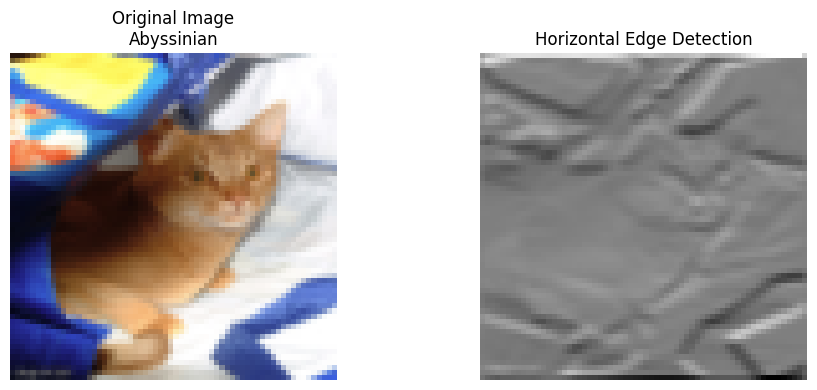

In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Get a single image from Oxford Pets
img, label = train_dataset[0]  # CHW format, [0,1] range
img_batch = img.unsqueeze(0)   # Add batch dim: (1,3,H,W)

# Horizontal edge detection kernel (same for R,G,B)
horizontal_kernel = torch.tensor(
    [[[-1, -1, -1],
      [ 0,  0,  0],
      [ 1,  1,  1]],  # Red

     [[-1, -1, -1],
      [ 0,  0,  0],
      [ 1,  1,  1]],  # Green

     [[-1, -1, -1],
      [ 0,  0,  0],
      [ 1,  1,  1]]]  # Blue
).unsqueeze(0).float()  # Shape: (1,3,3,3)

# Apply convolution
horizontal_feature_map = F.conv2d(img_batch, horizontal_kernel, stride=1, padding=1)

# Show original and feature map side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(img.permute(1, 2, 0))
axs[0].set_title(f"Original Image\n{train_dataset.classes[label]}")
axs[0].axis("off")

axs[1].imshow(horizontal_feature_map[0, 0].detach().numpy(), cmap="gray")
axs[1].set_title("Horizontal Edge Detection")
axs[1].axis("off")

plt.tight_layout()
plt.show()


**Vertical Edge Detection (PyTorch)**

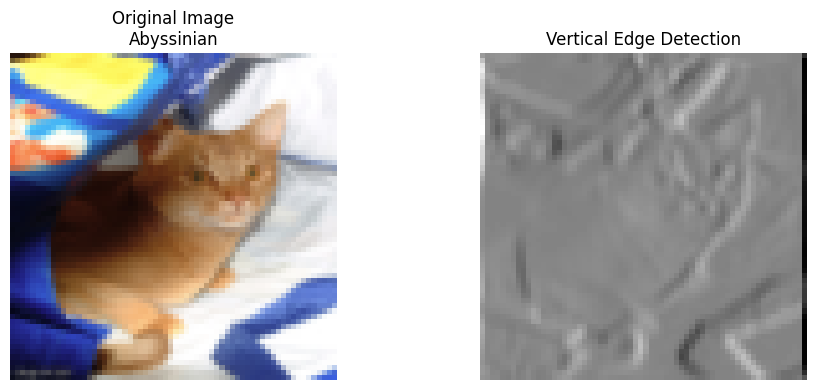

In [40]:
# Vertical edge detection kernel (same for R,G,B)
vertical_kernel = torch.tensor(
    [[[ -1,  0,  1],
      [ -1,  0,  1],
      [ -1,  0,  1]],  # Red

     [[ -1,  0,  1],
      [ -1,  0,  1],
      [ -1,  0,  1]],  # Green

     [[ -1,  0,  1],
      [ -1,  0,  1],
      [ -1,  0,  1]]]  # Blue
).unsqueeze(0).float()  # Shape: (1,3,3,3)

# Apply convolution
vertical_feature_map = F.conv2d(img_batch, vertical_kernel, stride=1, padding=1)

# Show original and feature map side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(img.permute(1, 2, 0))
axs[0].set_title(f"Original Image\n{train_dataset.classes[label]}")
axs[0].axis("off")

axs[1].imshow(vertical_feature_map[0, 0].detach().numpy(), cmap="gray")
axs[1].set_title("Vertical Edge Detection")
axs[1].axis("off")

plt.tight_layout()
plt.show()


**Horizontal Edge Detection (manually using Numpy)**

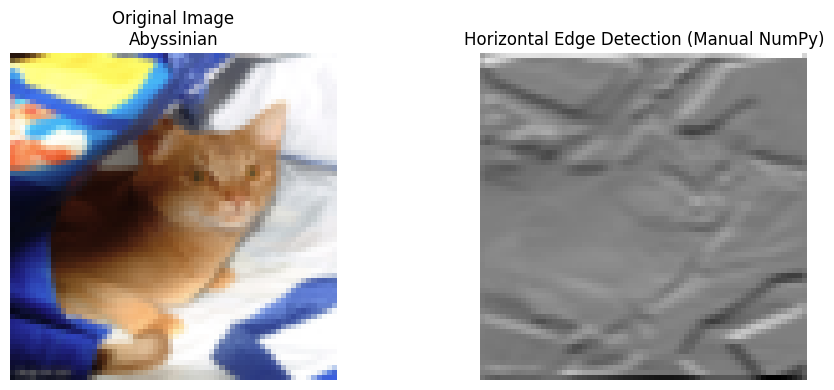

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1. Get an image (convert tensor to NumPy for demonstration)
# Assume `img` is the CHW tensor from your dataset (values 0–1)
img_np = img.permute(1, 2, 0).numpy()  # HWC format for convenience
img_np = (img_np * 255).astype(np.float32)  # scale to 0-255

# Split channels
R = img_np[:, :, 0]
G = img_np[:, :, 1]
B = img_np[:, :, 2]

# 2. Define horizontal edge kernel for each channel (same kernel)
kernel = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
])

def convolve2d_single_channel(channel, kernel, stride=1, padding=1):
    # Pad channel
    if padding > 0:
        channel = np.pad(channel, ((padding, padding), (padding, padding)), mode='constant', constant_values=0)

    kernel_h, kernel_w = kernel.shape
    h, w = channel.shape
    out_h = (h - kernel_h) // stride + 1
    out_w = (w - kernel_w) // stride + 1
    output = np.zeros((out_h, out_w))

    # Convolution
    for y in range(0, h - kernel_h + 1, stride):
        for x in range(0, w - kernel_w + 1, stride):
            region = channel[y:y+kernel_h, x:x+kernel_w]
            output[y//stride, x//stride] = np.sum(region * kernel)

    return output

# 3. Apply kernel to each channel
feature_R = convolve2d_single_channel(R, kernel)
feature_G = convolve2d_single_channel(G, kernel)
feature_B = convolve2d_single_channel(B, kernel)

# 4. Sum across channels to get final feature map
feature_map = feature_R + feature_G + feature_B

# 5. Visualize
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(img_np.astype(np.uint8))
axs[0].set_title(f"Original Image\n{train_dataset.classes[label]}")
axs[0].axis("off")

axs[1].imshow(feature_map, cmap="gray")
axs[1].set_title("Horizontal Edge Detection (Manual NumPy)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


**Reflection**

- By applying **different filters**, we generated **different feature maps**:
  - Horizontal edges → boundaries running left-to-right.
  - Vertical edges → boundaries running top-to-bottom.
- In CNNs, dozens (or even hundreds) of filters operate in parallel:
  - Capturing **complementary features** that, combined, form a rich understanding of the image.
- These feature maps are then passed to **pooling layers** (next section) to reduce size while keeping the most relevant patterns.

---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section.**

---

**✅ Code Task 5.1.5.1: Multi-Channel Convolution Using F.conv2d**

📘 Instruction</br>
Define a sharpening kernel (3×3) for RGB and apply it using F.conv2d to an image tensor from the dataset. Visualize the original image and the sharpened feature map side-by-side.

Hints:
- Make sure kernel shape is (1, 3, 3, 3) and of type float.
- Use unsqueeze(0) to add batch dimension.
- Use .detach().numpy() for plotting the result.

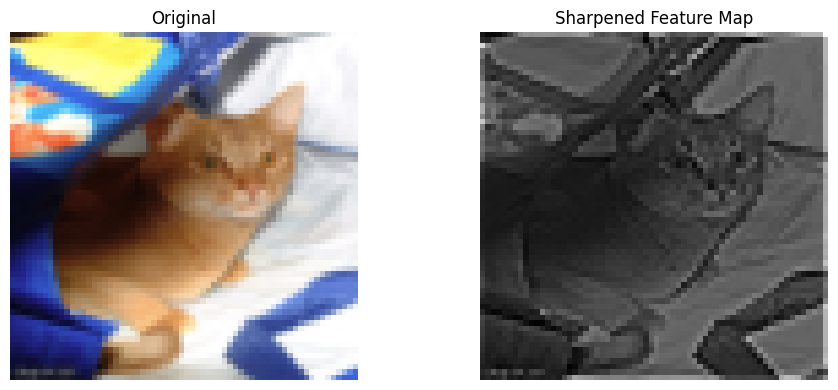

In [68]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define sharpening kernel (same across RGB)
CT_sharpen_kernel = torch.tensor(
    [[[ 0, -1,  0],
      [-1,  5, -1],
      [ 0, -1,  0]],

     [[ 0, -1,  0],
      [-1,  5, -1],
      [ 0, -1,  0]],

     [[ 0, -1,  0],
      [-1,  5, -1],
      [ 0, -1,  0]]]
).unsqueeze(0).float()

# Prepare input image (batch, channel, H, W)
CT_img_batch = img.unsqueeze(0)

# Apply convolution
CT_sharpen_map = F.conv2d(CT_img_batch,CT_sharpen_kernel, stride=1, padding=1)

# Visualize
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(img.permute(1, 2, 0))
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(CT_sharpen_map[0, 0].detach().numpy(), cmap="gray")
axs[1].set_title("Sharpened Feature Map")
axs[1].axis("off")

plt.tight_layout()
plt.show()  # Shape: (1,3,3,3)



---

**✅ Code Task 5.1.5.2: Manual Convolution on RGB Channels (NumPy)**

📘 Instruction</br>
Using the convolve2d_single_channel() function, apply a sharpening kernel to each of the R, G, and B channels of an image. Then, sum the results and visualize the final feature map.

Hints:
- Use the same sharpening kernel on each channel.
- Use the R, G, and B variables already extracted from the image.
- Visualize the result with imshow().

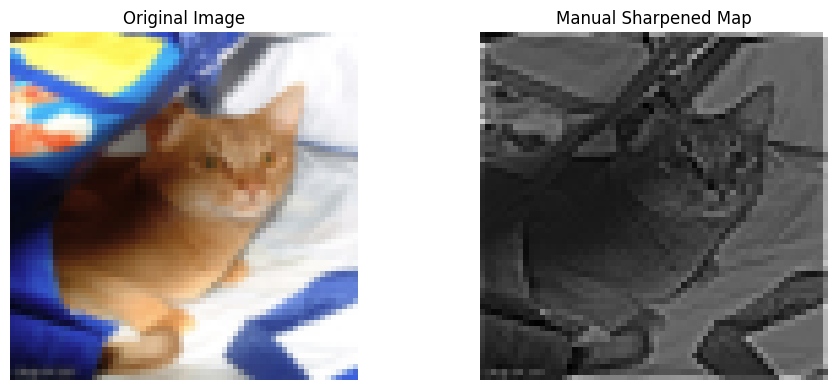

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Define sharpening kernel (NumPy)
CT_sharpen_np_kernel = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])
CT_feat_R = convolve2d_single_channel(R, CT_sharpen_np_kernel, stride=1, padding=1)
CT_feat_G = convolve2d_single_channel(G, CT_sharpen_np_kernel, stride=1, padding=1)
CT_feat_B = convolve2d_single_channel(B, CT_sharpen_np_kernel, stride=1, padding=1)
# Apply convolution to each channel
CT_feat_R = convolve2d_single_channel(R, CT_sharpen_np_kernel)
CT_feat_R = convolve2d_single_channel(G, CT_sharpen_np_kernel)
CT_feat_B = convolve2d_single_channel(B, CT_sharpen_np_kernel)

# Combine results
CT_sharpened_feature_map =CT_feat_R+CT_feat_R+CT_feat_B

# Plot result
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(img_np.astype(np.uint8))
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(CT_sharpened_feature_map, cmap="gray")
axs[1].set_title("Manual Sharpened Map")
axs[1].axis("off")

plt.tight_layout()
plt.show()


---

In [70]:
from IPython.display import VimeoVideo

# Bigger video
VimeoVideo("1112915252", h="3298dbabb7", width=700, height=450)

### **6. Pooling Layers**

**Why Pooling?**

When convolutional layers generate feature maps, they preserve most of the original spatial details — every small change in the input image is reflected in these maps. While this is useful for capturing fine details, it quickly becomes inefficient as networks get deeper: feature maps remain large, computations become heavier, and the model risks focusing too much on tiny pixel-level variations.

Pooling layers solve this by **condensing the information** in a feature map. Instead of looking at every pixel, pooling looks at small regions (like `2×2` blocks) and summarizes them — for example, by taking the **maximum value** (max pooling) or the **average value** (average pooling). This achieves two things at once:  
1. It **reduces the size** of the data flowing through the network, making computations faster and reducing the number of parameters in later layers.  
2. It makes the network more **robust to small shifts or distortions** in the input image — if an object moves slightly, the strongest features (like edges or textures) still appear in the pooled map.

In simpler terms, pooling acts like a way of **zooming out**: we keep the most important patterns and ignore small irrelevant variations, helping the network focus on **what** is present rather than **exactly where** it is.


**Types of Pooling**

1. **Max Pooling**

Selects the **maximum value** in each window:

$$
\text{MaxPool}(2\times 2) \to \text{take max of each 2x2 block}
$$

2. **Average Pooling**

Takes the **average value** in each window:

$$
\text{AvgPool}(2\times 2) \to \text{average values in each 2x2 block}
$$


**Visual Intuition**

Example: $4 \times 4$ feature map pooled with $2 \times 2$ max pooling.

**Original Feature Map**


$$
\begin{bmatrix}
1 & 2 & 5 & 6 \\
3 & 4 & 7 & 8 \\
9 & 10 & 13 & 14 \\
11 & 12 & 15 & 16
\end{bmatrix}
$$

**After $2 \times 2$ Max Pooling**

$$
\begin{bmatrix}
4 & 8 \\
12 & 16
\end{bmatrix}
$$

Pooling reduces dimensions by a factor of 2 (from $4\times4$ to $2\times2$) while keeping the **strongest activations**.



**What We’ll Do**

1. Toy NumPy example: Max vs. Average pooling on a small matrix.
2. PyTorch example: Apply pooling to an **edge-detected feature map** from Section 5.
3. Observe **downsampling** and discuss **translation invariance**.


**Code Cell 1 – Toy Example (NumPy Max and Average Pooling)**

In [71]:
import numpy as np

# Create a simple 4x4 feature map
feature_map = np.array([
    [1, 2, 5, 6],
    [3, 4, 7, 8],
    [9, 10, 13, 14],
    [11, 12, 15, 16]
])

def pool2d(matrix, size=2, mode="max"):
    H, W = matrix.shape
    pooled = []
    for i in range(0, H, size):
        row = []
        for j in range(0, W, size):
            window = matrix[i:i+size, j:j+size]
            if mode == "max":
                row.append(np.max(window))
            else:
                row.append(np.mean(window))
        pooled.append(row)
    return np.array(pooled)

max_pooled = pool2d(feature_map, size=2, mode="max")
avg_pooled = pool2d(feature_map, size=2, mode="avg")

print("Original Feature Map:\n", feature_map)
print("\nMax Pooled (2x2):\n", max_pooled)
print("\nAverage Pooled (2x2):\n", avg_pooled)


Original Feature Map:
 [[ 1  2  5  6]
 [ 3  4  7  8]
 [ 9 10 13 14]
 [11 12 15 16]]

Max Pooled (2x2):
 [[ 4  8]
 [12 16]]

Average Pooled (2x2):
 [[ 2.5  6.5]
 [10.5 14.5]]


**Code Cell 2 – Pooling on Oxford Pet Feature Map (PyTorch)**

We will reuse the horizontal edge detection feature map from Section 5.

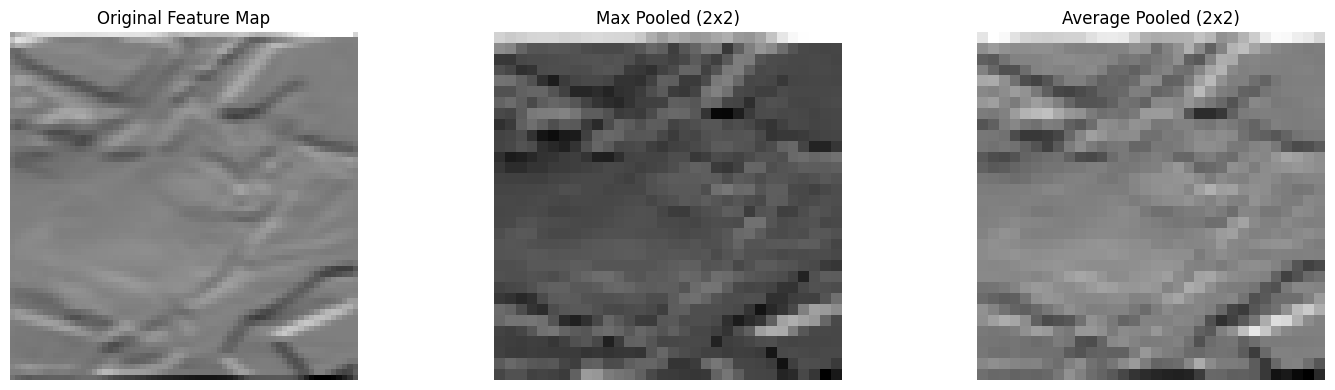

In [72]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Apply Max Pooling (2x2) on the feature map
max_pooled_map = F.max_pool2d(horizontal_feature_map, kernel_size=2, stride=2)

# Apply Average Pooling (2x2) on the feature map
avg_pooled_map = F.avg_pool2d(horizontal_feature_map, kernel_size=2, stride=2)

# Plot original vs pooled feature maps
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].imshow(horizontal_feature_map[0, 0].detach().numpy(), cmap="gray")
axs[0].set_title("Original Feature Map")
axs[0].axis("off")

axs[1].imshow(max_pooled_map[0, 0].detach().numpy(), cmap="gray")
axs[1].set_title("Max Pooled (2x2)")
axs[1].axis("off")

axs[2].imshow(avg_pooled_map[0, 0].detach().numpy(), cmap="gray")
axs[2].set_title("Average Pooled (2x2)")
axs[2].axis("off")

plt.tight_layout()
plt.show()


**Reflection**

- **Max Pooling** preserves the **strongest activations** — useful for detecting whether a feature is present, regardless of exact position.
- **Average Pooling** provides **smoother representations** — less common in modern CNNs but sometimes useful for specific tasks.
- Pooling reduces spatial dimensions, enabling deeper networks without exploding computation.

**Next:** We explore how **stacking convolution + pooling layers** builds a **feature hierarchy** — from edges → textures → object parts → objects.

---

**✅ ALERT: You are now ready to answer the Multiple Choice Questions for this section.**

---

**✅ Code Task 5.1.6.1: Average Pooling on a Sample Image**

📘 Instruction</br>
Apply a 2×2 average pooling operation using F.avg_pool2d to a resized image from your custom dataset. Visualize the original image and the pooled output side-by-side.

Hints:
- Use CT_subset_32 created earlier (with 32×32 resize).
- Don’t forget to unsqueeze(0) to add batch dimension.
- Use permute(1, 2, 0) to convert tensor for plotting.

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Get a sample from resized dataset
CT_sample_img, _ = CT_subset_32[3,32,32]  # Shape: (3, 32, 32)
CT_sample_batch = CT_sample_img.unsqueeze(0)

# Apply average pooling (2x2)
CT_avg_pooled = F.avg_pool2d(CT_sample_batch, kernel_size=..., stride=1)

# Visualize original vs pooled
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(CT_sample_img.permute(1, 2, 0))
axs[0].set_title("Original (32×32)")
axs[0].axis("off")

axs[1].imshow(...[0].permute(1, 2, 0).detach().numpy())
axs[1].set_title("Avg Pooled (16×16)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


---

### **7. Hierarchical Feature Learning**

Up to now, we’ve explored the **building blocks** of CNNs: convolutions, multi-channel processing, and pooling. But the real power of CNNs emerges when we **stack these layers** — each layer takes the features detected by the previous one and combines them into something more complex. This creates a **hierarchy of features**, where simple patterns evolve into sophisticated representations of the input.

**How Does This Hierarchy Work?**

- **Early layers (closest to the raw image):**  
  These layers learn to detect the simplest building blocks — edges, lines, and basic color contrasts. This is exactly what we saw with our manual edge filters. At this stage, the network doesn’t “know” what an ear or paw is; it’s only identifying basic shapes and boundaries.

- **Middle layers:**  
  As we stack more convolutions, these edge detectors combine to form **textures and small patterns** — like fur, eyes, or whisker arrangements. Importantly, these are **not predefined by us**. The network *learns* which combinations of edges are useful for distinguishing classes during training.

- **Deeper layers:**  
  Further combinations form **larger parts** of the object — like ears, snouts, or tails. These parts are more abstract: the network begins to recognize “this curved edge + texture = ear,” even if the ear appears in different positions or sizes.

- **Final layers:**  
  The deepest layers integrate everything into **whole-object representations** (e.g., “This collection of textures and parts is a Persian cat”). By this point, the feature maps no longer resemble edges or textures — they encode high-level concepts useful for classification.

**Where Does Pooling Fit In?**

Pooling layers are interspersed between convolution layers to **gradually reduce spatial detail** while retaining the most important features. Think of it as zooming out: early layers focus on precise edge positions, while later layers care about *what* features exist rather than *exactly where* they are. This combination of convolution + pooling allows CNNs to be **both detailed and flexible**.

**Why Is This Powerful?**

- This hierarchy mimics **how human vision works** — from detecting edges to recognizing complex objects.  
- We don’t manually design “ear detectors” or “fur detectors.” The network learns what’s useful based on the training data.  
- Each layer **builds on previous layers**, which is why depth (stacking layers) makes CNNs capable of solving complex visual tasks.


In short, CNNs transform raw pixels into a layered understanding of the image — starting with lines, building up to patterns, and finally recognizing whole objects like cat or dog breeds. This layered approach is what makes CNNs so effective and versatile in computer vision.

---

### **8. Summary & Transition**

In this notebook, we explored the **foundational building blocks of CNNs** — understanding not just how they work, but why they are so effective for images.

**Convolutional Layers**  
We saw how convolutions use small filters to detect **local patterns** (like edges) while preserving the **spatial structure** of images. Parameter sharing makes this approach far more efficient than MLPs, which flatten images and lose spatial relationships.

**Multi-Channel Convolutions**  
Real images are RGB, so each filter operates across **all three channels** and sums the results to form a feature map. Stacking multiple filters lets the network detect a variety of patterns — for example, some filters may learn horizontal edges, others vertical edges, and others more complex textures.

**Pooling Layers**  
Pooling layers act as a way to **summarize information**: they downsample feature maps and make the network more robust to small shifts (translation invariance). This helps later layers focus on *what* features exist rather than *exactly where* they are.

**Hierarchical Feature Learning**  
By stacking convolution + pooling layers, CNNs build a **feature hierarchy**:  
- Early layers learn edges and color contrasts.  
- Middle layers combine these into textures and patterns.  
- Deeper layers recognize object parts (like ears or snouts).  
- Final layers put these parts together to recognize whole objects (e.g., specific dog or cat breeds).  

This progression is not manually designed — it emerges naturally during training, which is what makes CNNs so powerful.


```text
      Input Image (3×H×W)
               │
               ▼
   Convolution + Pooling Layers
      (edges → textures → parts)
               │
               ▼
    Fully Connected Layers (FC)
      (combine all features)
               │
               ▼
   Output (Breed Prediction)
```

**Where We’re Headed Next**

- In **Notebook 2**, we will:
  - Build our **first CNN in PyTorch** using `nn.Conv2d`, `nn.ReLU`, and `nn.MaxPool2d`.
  - Train it on the **Oxford-IIIT Pets dataset**.
  - Evaluate its accuracy and visualize predictions.

**Core idea:**  
We are now ready to **move from theory and toy examples → real CNN architectures** applied to actual image data.
